In [1]:
import os
import pandas as pd

tweets = []
sentiments = []

# Get data
train_file = '/home/gkc/ProjectData/tweet-sentiment-extraction/train.csv'
test_file = '/home/gkc/ProjectData/tweet-sentiment-extraction/test.csv'

train_df = pd.read_csv(train_file).astype(str)
test_df = pd.read_csv(test_file).astype(str)

In [2]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27481 non-null  object
 2   selected_text  27481 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [5]:
import numpy as np

# Separate and format data to feed into model
#train_data = train_df['selected_text'].to_numpy()
train_data = train_df['text'].to_numpy()
train_labels = pd.get_dummies(train_df['sentiment'])
test_data = test_df['text'].to_numpy()
test_labels = pd.get_dummies(test_df['sentiment'])

In [6]:
# Create label index for later use
train_cats = train_df["sentiment"].astype('category')
cat_index = train_cats.cat.categories

cat_index

Index(['negative', 'neutral', 'positive'], dtype='object')

In [7]:
test_labels.head()

,negative,neutral,positive
0,0,1,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1


In [8]:
train_labels.head()

,negative,neutral,positive
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Establish hyperparameters
vocab_size = 10000
embedding_dim = 10
max_length = 25
trunc_type='post'
oov_tok = "<OOV>"

In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data)
word_index = tokenizer.word_index
total_words = len(tokenizer.word_index) + 1

In [11]:
total_words

26600

In [12]:
# Convert train and test data to sequences
train_sequences = tokenizer.texts_to_sequences(train_data)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)
test_sequences = tokenizer.texts_to_sequences(test_data)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)

In [13]:
train_padded

array([[   0,    0,    0, ...,    2,  151,   49],
       [   0,    0,    0, ...,   11, 1470, 2305],
       [   0,    0,    0, ...,   10,    1,   18],
       ...,
       [   0,    0,    0, ...,  658,  879, 2852],
       [   0,    0,    0, ...,   29,  701,    7],
       [   0,    0,    0, ..., 2306,  236,  669]], dtype=int32)

In [14]:
# Build Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, recurrent_dropout=0.35, dropout=0.35, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, recurrent_dropout=0.35, dropout=0.35)),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 10)            100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 64)            8448      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                18816     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 127,459
Trainable params: 127,459
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Train model
num_epochs = 3
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels))

Epoch 1/3
859/859 [==============================] - 123s 133ms/step - loss: 0.9660 - accuracy: 0.5083 - val_loss: 0.7032 - val_accuracy: 0.6969
Epoch 2/3
859/859 [==============================] - 104s 121ms/step - loss: 0.6621 - accuracy: 0.7220 - val_loss: 0.6579 - val_accuracy: 0.7136
Epoch 3/3
859/859 [==============================] - 110s 128ms/step - loss: 0.5627 - accuracy: 0.7755 - val_loss: 0.6595 - val_accuracy: 0.7261


In [16]:
model.save('tweet_model.h5')

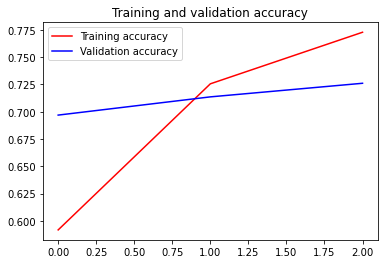

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

# Plot accuracy vs loss to gain a better understanding of the model's performance

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [18]:
# Predict a fake tweet
def predict_tweet(tweet):
    token_sequence = tokenizer.texts_to_sequences([tweet])[0]
    token_padded = pad_sequences([token_sequence], maxlen=max_length, truncating=trunc_type)
    predicted = model.predict(token_padded)
    predicted_class = np.argmax(predicted, axis=-1)
    predicted_cat = str(cat_index[predicted_class].tolist())

    print(predicted)
    print(predicted_cat)
    
fake_tweet = "i love pizza"
predict_tweet(fake_tweet)

[[0.00547712 0.03274165 0.96178126]]
['positive']


In [45]:
# Visualize embeddings
from tensorboard.plugins import projector

# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='/home/gkc/logs/tweet_project/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for words in word_index:
        f.write("{}\n".format(words))

# Save the weights we want to analyse as a variable
weights = tf.Variable(model.layers[0].get_weights()[0])
# Create a checkpoint from embedding
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()

# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [46]:
%load_ext tensorboard
%tensorboard --logdir '/home/gkc/logs/tweet_project/'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 7198), started 0:00:43 ago. (Use '!kill 7198' to kill it.)